In [1]:
import tensorflow as tf


physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/#:~:text=In%20the%202014%20ImageNet%20Classification,present%20in%20our%20Food%20dataset.

In [24]:
import os
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import layers, models, Model, optimizers
from PIL import ImageFile,Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [25]:
BATCH_SIZE = 64

train_generator =ImageDataGenerator( validation_split=0.15,
                                    #rescale=1./255,
                                   preprocessing_function=preprocess_input )

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # MobileNetV2

In [26]:
train_data_dir ='D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/'
test_data_dir = 'D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/'

total_classes = sorted(os.listdir(train_data_dir))
print(total_classes)


['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [27]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(100, 100),
                                             class_mode=None,
                                             classes=total_classes,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 57612 images belonging to 131 classes.
Found 10080 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [5]:
# Model Creation
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(100,100,3),
                   pooling='avg',classes=131,
                   weights='imagenet')
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
     
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(32,activation='relu')(top_model)
    top_model = Dense(16,activation='relu')(top_model)
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
# Use a smaller learning rate
input_shape = (100,100, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=len(total_classes)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 20

#optim_2 = Adam(lr=0.0001)

# First we'll train the model without Fine-tuning
mobile_model_ft = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [7]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()
csv_logger = CSVLogger('D:/TQ/Fruits360/MobileNet_Model_July_25_Processed_20.csv', separator=',')

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='D:/TQ/Fruits360/MobileNet_Model_July_25_20.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [8]:
mobile_model_ft.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][0]']           

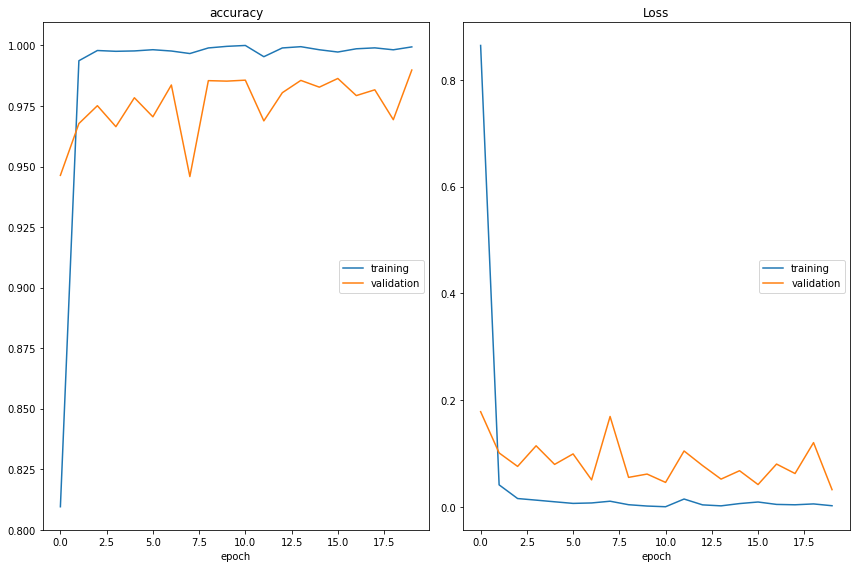

accuracy
	training         	 (min:    0.809, max:    1.000, cur:    0.999)
	validation       	 (min:    0.946, max:    0.990, cur:    0.990)
Loss
	training         	 (min:    0.000, max:    0.864, cur:    0.002)
	validation       	 (min:    0.032, max:    0.178, cur:    0.032)
900/900 [==============================] - 88s 98ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0322 - val_accuracy: 0.9898
CPU times: total: 1h 6min 11s
Wall time: 47min 29s


In [9]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
mobile_ft_history = mobile_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[csv_logger,tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [10]:
 mobile_model_ft.save("D:/TQ/Fruits360/Results/MobileNet_Model_Feb_9_20.h5")

In [13]:
from tensorflow.keras import models
model = models.load_model('D:/TQ/Fruits360/Results/MobileNet_Model_Feb_9_20.h5')


In [14]:
# Generate predictions
#vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

test_predictions = model.predict(testgen)
predicted_classes = np.argmax(test_predictions, axis=1)

22688/22688 [==============================] - 233s 10ms/step


In [19]:
true_classes = testgen.classes

mobilenet_accuracy = accuracy_score(true_classes, predicted_classes)
print("MobileNet Model Accuracy without Fine-Tuning: {:.2f}%".format(mobilenet_accuracy * 100))

MobileNet Model Accuracy without Fine-Tuning: 95.20%


In [20]:
report = classification_report(testgen.classes, predicted_classes, target_names=total_classes)
print(report)

                     precision    recall  f1-score   support

     Apple Braeburn       0.78      1.00      0.87       164
 Apple Crimson Snow       0.94      0.93      0.94       148
     Apple Golden 1       0.98      0.76      0.86       160
     Apple Golden 2       0.83      0.90      0.86       164
     Apple Golden 3       0.78      0.86      0.82       161
 Apple Granny Smith       0.96      0.91      0.93       164
    Apple Pink Lady       0.87      0.90      0.89       152
        Apple Red 1       0.93      0.79      0.85       164
        Apple Red 2       0.80      0.73      0.76       164
        Apple Red 3       0.98      0.93      0.95       144
Apple Red Delicious       1.00      0.99      1.00       166
 Apple Red Yellow 1       1.00      0.95      0.97       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

In [21]:
cm = confusion_matrix(true_classes, predicted_classes)

print(cm)


[[164   0   0 ...   0   0   0]
 [  0 138   0 ...   0   0   0]
 [  0   0 121 ...   0   0  39]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 156]]


In [22]:
cm.to_csv('D:/TQ/Fruits360/Results/MobileNetConfusionMatrix.csv')


AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

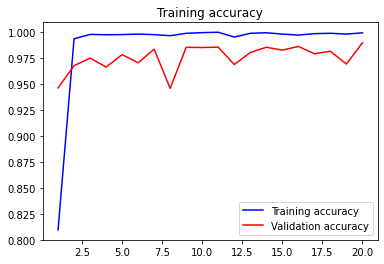

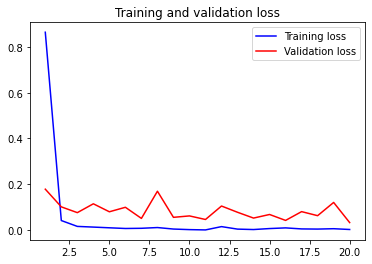

In [81]:
acc = mobile_ft_history.history['accuracy']
val_acc = mobile_ft_history.history['val_accuracy']
loss = mobile_ft_history.history['loss']
val_loss = mobile_ft_history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.savefig('D:/TQ/Fruits360/Results/MobileNetNetFineTunedAccuracy_Feb_9.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('D:/TQ/Fruits360/Results/MobileNetFineTunedLoss_Feb_9.jpg')

In [28]:
file_names=testgen.filenames  # save list of test files names to be used later
tlabels=testgen.labels # save test labels to be used later
class_dict=testgen.class_indices
# code below determines test batch size and test steps
# so you go through the test images exactly once
length=len(file_names) # determine number of images
b_max=80 # set maximum batch size you will allow
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]
test_steps=int(length/BATCH_SIZE)
# make predictions
preds=test_predictions
new_dict={} 
for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value=class_dict[key]
    new_dict[value]=key
error_list=[] # empty list to store if the prediction was correct or not
true_predictions = {}
false_predictions = {}
error_file_list=[]
a = b = 1
for i, p in enumerate(preds):
    pred_index=np.argmax(p) # get the index that has the highest probability
    if pred_index == tlabels[i]: #correct predictions
      true_predictions[a] = {}
      true_predictions[a]['PredictedClass'] = new_dict[pred_index]
      true_predictions[a]['TrueClass'] = new_dict[tlabels[i]]
      true_predictions[a]['FileName'] = file_names[i]
      true_predictions[a]['Status'] = 'No'
      error_list.append('No')
      a+=1
    else:
      error_list.append('Yes')
      false_predictions[b] = {}
      false_predictions[b]['PredictedClass'] = new_dict[pred_index]
      false_predictions[b]['TrueClass'] = new_dict[tlabels[i]]
      false_predictions[b]['FileName'] = file_names[i]
      false_predictions[b]['Status'] = 'Yes'
      b+=1
      #print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {error_status:10s}')  
      
print("Total Images: ",len(error_list))
print("True Predictions: ",len(true_predictions))
print("False Predictions: ",len(false_predictions))

Total Images:  22688
True Predictions:  21598
False Predictions:  1090


In [29]:
print("---------------False Predictions---------")
print('PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS' ) # adjust spacing based on your class names
for i in range(45,78):
  pred_class = false_predictions[i]['PredictedClass']  # find the predicted class based on the index
  true_class = false_predictions[i]['TrueClass'] # use the test label to get the true class of the test file
  file = false_predictions[i]['FileName']
  status = false_predictions[i]['Status']
  print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {status:10s}') 

---------------False Predictions---------
PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS
    Watermelon       Apple Golden 1    Apple Golden 1\143_100.jpg   Yes       
    Watermelon       Apple Golden 1    Apple Golden 1\96_100.jpg   Yes       
    Watermelon       Apple Golden 1    Apple Golden 1\97_100.jpg   Yes       
    Watermelon       Apple Golden 1    Apple Golden 1\98_100.jpg   Yes       
    Watermelon       Apple Golden 1    Apple Golden 1\99_100.jpg   Yes       
    Grape White       Apple Golden 2    Apple Golden 2\80_100.jpg   Yes       
    Apple Golden 3       Apple Golden 2    Apple Golden 2\r_58_100.jpg   Yes       
    Apple Golden 3       Apple Golden 2    Apple Golden 2\r_66_100.jpg   Yes       
    Apple Golden 3       Apple Golden 2    Apple Golden 2\r_68_100.jpg   Yes       
    Apple Golden 3       Apple Golden 2    Apple Golden 2\r_69_100.jpg   Yes       
    Apple Golden 3       Apple Golden 2    Apple Golden 2\r_70_100.

In [30]:
print("---------------------True Predictions--------------------\n")
print('PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS' ) # adjust spacing based on your class names
for i in range(1,20765):
  pred_class = true_predictions[i]['PredictedClass']  # find the predicted class based on the index
  true_class = true_predictions[i]['TrueClass'] # use the test label to get the true class of the test file
  file = true_predictions[i]['FileName']
  status = true_predictions[i]['Status']
  print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {status:10s}') 

---------------------True Predictions--------------------

PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS
    Apple Braeburn       Apple Braeburn    Apple Braeburn\321_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\322_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\323_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\324_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\325_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\326_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\327_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\32_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\33_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\34_100.jpg   No        
    Apple Braeburn       Appl

In [31]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.9.0


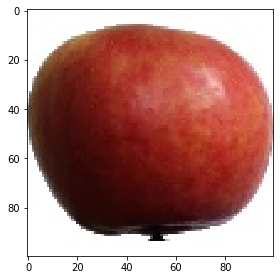

In [23]:
Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Crimson Snow/80_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_63_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pepper Green/100_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Banana/98_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Strawberry/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pineapple Mini/r_231_100.jpg")

#Xi = skimage.transform.resize(Xi, (100,100)) 

skimage.io.imshow(Xi) # Show image before inception preprocessing

Xi = preprocess_input(Xi)


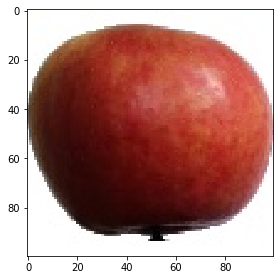

In [24]:
skimage.io.imshow((Xi+1)/2)

In [33]:
#skimage.io.imshow(np.uint8(Xi)/255.0)
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

#Xi_reversed = deprocess_img(Xi)

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


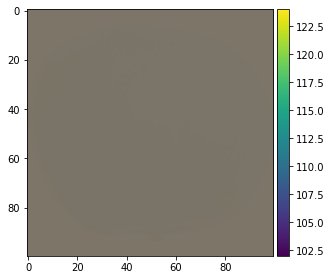

In [26]:
skimage.io.imshow(Xi_reversed)


In [60]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

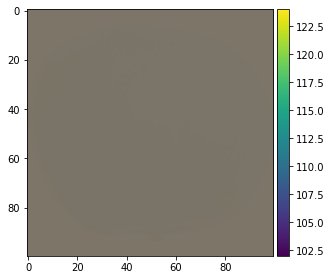

In [27]:
skimage.io.imshow(Xi_reversed)
#skimage.io.imshow(Xi)



In [28]:
preds = model.predict(Xi[np.newaxis,:,:,:])
#print(preds)
print(total_classes[np.argmax(preds)])

1/1 [==============================] - 0s 34ms/step
Apple Crimson Snow


In [29]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([ 1, 70,  6, 65,  0], dtype=int64)

In [30]:
for x in top_pred_classes:
    print(total_classes[x])

Apple Crimson Snow
Nectarine
Apple Pink Lady
Mango Red
Apple Braeburn


# LIME Implementation

In [34]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = keras.utils.load_img(img_path, target_size=(100, 100))
        x = keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

1/1 [==============================] - 0s 31ms/step


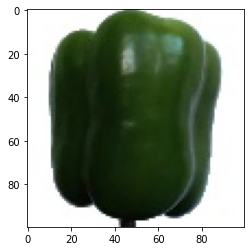

In [75]:
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/Test_Images/Red_Apple.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_63_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pepper Green/100_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Banana/98_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Strawberry/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Apple Braeburn/321_100.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pineapple Mini/r_231_100.jpg")
#D:\TQ\Fruits360\fruits-360_dataset\fruits-360\Test\Cactus fruit \Cauliflower

images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pepper Green/','100_100.jpg')])
#images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pineapple Mini/','r_231_100.jpg')])
#images = transform_img_fn([os.path.join('D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Banana/','98_100.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
#plt.imshow(deprocess_img(images[0]))
plt.imshow((images[0]+1)/2)
preds = model.predict(images)
#for x in preds:
 #   print(x)

In [76]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes
for x in top_pred_classes:
    print(total_classes[x])

Pepper Green
Apple Red Yellow 2
Tomato not Ripened
Tomato Heart
Pepper Orange


In [77]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
explainer = lime_image.LimeImageExplainer()

In [79]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
CPU times: total: 9.41 s
Wall time: 9.01 s


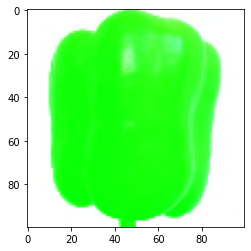

In [80]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=True)
#lt.imshow(mark_boundaries(deprocess_img(temp), mask))  
#plt.imshow(mark_boundaries((((temp+1)/2).astype("uint8")), mask)) 
plt.imshow(mark_boundaries(((temp+1)/2), mask))
#plt.imshow(mark_boundaries(temp.astype("uint8"), mask))



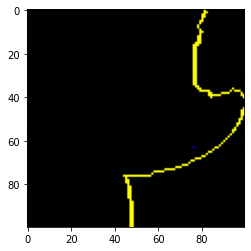

In [52]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=50, hide_rest=False)
plt.imshow(mark_boundaries(temp.astype(np.uint8), mask))  #from skimage.segmentation import mark_boundaries

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


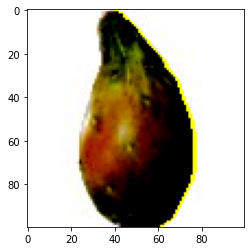

In [104]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=100, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
#img_boundry2 = mark_boundaries(deprocess_img(temp), mask)
#plt.imshow(img_boundry2)

#plt.imshow(mark_boundaries(((temp+1)/2, mask)))

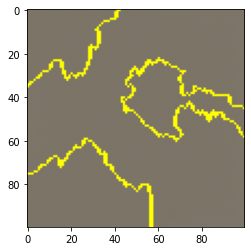

In [135]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(deprocess_img(temp), mask))

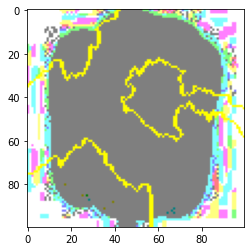

In [140]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=100, hide_rest=False)
plt.imshow(mark_boundaries((temp+1)/2, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


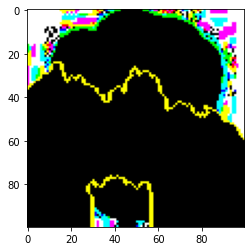

In [144]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

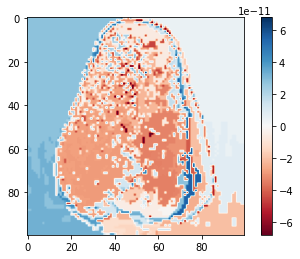

In [91]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[1]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
#plt.imshow(mark_boundaries(deprocess_img(temp), mask))

# Explaining Pepper Green\100_100

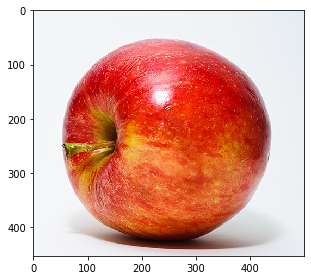

In [141]:
Xi = skimage.io.imread("D:/TQ/Fruits360/Test_Images/Red_Apple.jpg")
#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Pepper Green/100_100.jpg")

#Xi = skimage.io.imread("D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/Strawberry/321_100.jpg")

#Xi = skimage.transform.resize(Xi, (100,100)) 

skimage.io.imshow(Xi) # Show image before inception preprocessing

Xi = preprocess_input(Xi)


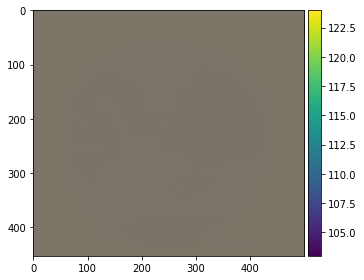

In [142]:
skimage.io.imshow(deprocess_img(Xi))


In [143]:
preds = vgg_model.predict(Xi[np.newaxis,:,:,:])
#print(preds)
print(total_classes[np.argmax(preds)])

NameError: name 'vgg_model' is not defined

In [166]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([11, 89,  1, 66, 28], dtype=int64)

In [167]:
for x in top_pred_classes:
    print(total_classes[x])

Apple Red Yellow 1
Pear Red
Apple Crimson Snow
Mangostan
Cherry Rainier


In [168]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

811

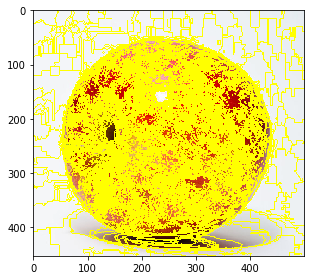

In [169]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(deprocess_img(Xi), superpixels))

In [170]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


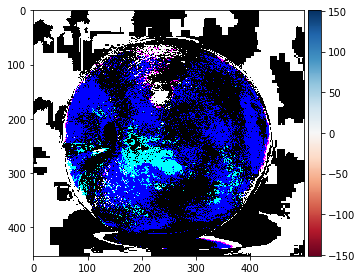

In [171]:
perturbed = perturb_image(Xi,perturbations[49],superpixels)
skimage.io.imshow(perturbed)

In [172]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = vgg_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 42ms/step


(150, 1, 131)

In [173]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [174]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [175]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-5.08972856e-05, -7.16270762e-05,  2.27353832e-05,  7.26960340e-06,
       -2.59345590e-05,  6.61709137e-05, -1.40298241e-05,  4.45490390e-05,
        2.28553297e-05, -3.11254170e-05, -6.70166960e-05, -3.72329355e-05,
        3.22525857e-05, -3.00710313e-05,  2.15647905e-05,  2.64085560e-05,
       -3.09024905e-05, -2.42919732e-05,  6.00597137e-05,  3.64970985e-05,
        5.83992581e-05, -2.48680117e-05, -1.41279114e-05,  1.64939938e-05,
       -4.94042022e-05,  7.04640026e-05, -1.32144790e-04, -3.39620633e-05,
        2.45780621e-05, -1.30134712e-06,  7.15512782e-05,  3.11306639e-05,
       -6.13878813e-05, -1.13559466e-04, -3.24015636e-05,  2.69378975e-05,
        2.13561425e-05,  7.53635269e-06,  5.63187205e-05, -7.80965265e-05,
       -9.04162826e-05,  1.30802476e-05, -4.32697158e-05,  7.02414812e-05,
       -4.93326637e-05, -3.14208211e-06, -1.65013179e-05, -2.44467747e-05,
       -6.37037659e-05, -1.77816819e-05,  3.12136286e-05,  7.48692932e-05,
       -3.04703385e-05, -

In [176]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([422, 791, 702, 536], dtype=int64)

In [192]:
for x in top_pred_classes:
    print(total_classes[x])

Pear Red
Cherry Rainier
Nectarine
Apple Red Yellow 1
Mangostan


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


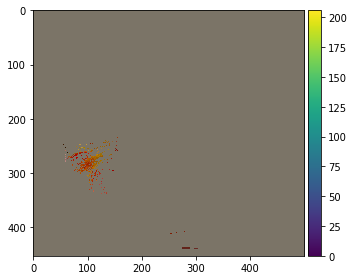

In [177]:
mask = np.zeros(num_superpixels)

mask[top_features]= True #Activate top superpixels
top_feature_perturbed = perturb_image(Xi,mask,superpixels)
#print(top_feature_perturbed)
skimage.io.imshow(deprocess_img(top_feature_perturbed))
